In [2]:
# From https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/ 
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.metrics import recall_score, classification_report, confusion_matrix
wine = pd.read_csv('../datasets/wine.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Learning Curve Definition

In [3]:
# Courtesy of http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# Confusion Matrix Definition

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data

In [5]:
wine.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [6]:
X = wine.drop('quality', axis=1).values
y = wine['quality'].values

# Data Preprocessing

In [7]:
scaler = StandardScaler()

In [8]:
# Fit to training data
scaler.fit(X)
X = scaler.transform(X)

# Train Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

# Default Model

In [9]:
clf = svm.SVC()
clf.fit(X_train, y_train)
print clf.score(X_test, y_test)

0.6


Confusion matrix, without normalization
[[  0   0   2   0   0   0]
 [  0   0  16   7   0   0]
 [  0   0 211  67   0   0]
 [  0   0  84 154  10   0]
 [  0   0   3  59  19   0]
 [  0   0   0   3   5   0]]


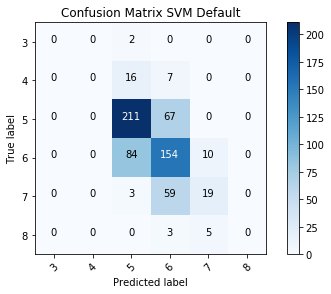

In [10]:
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['3','4','5','6','7','8'], title='Confusion Matrix SVM Default')
plt.show()
plt.clf()

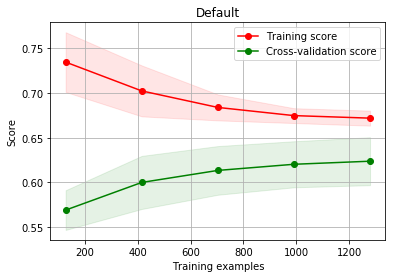

In [13]:
#     Plot learning curve
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
clf = svm.SVC()

plot_learning_curve(clf, "Default", X, y, ylim=None, cv=cv, n_jobs=4).show()

# RBF Kernel Grid Search

# Tuning hyper-parameters for accuracy


/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2

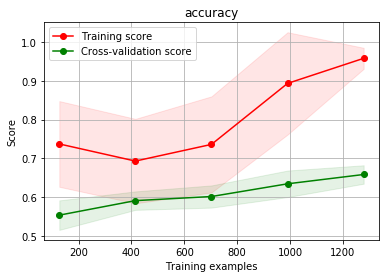

Best parameters set found on development set:
{'C': 10, 'gamma': 0.01}
Grid scores on development set:
0.530 (+/-0.067) for {'C': 1, 'gamma': 1}
0.575 (+/-0.073) for {'C': 1, 'gamma': 0.01}
0.556 (+/-0.070) for {'C': 1, 'gamma': 0.001}
0.426 (+/-0.004) for {'C': 1, 'gamma': 0.0001}
0.502 (+/-0.048) for {'C': 10, 'gamma': 1}
0.582 (+/-0.073) for {'C': 10, 'gamma': 0.01}
0.568 (+/-0.075) for {'C': 10, 'gamma': 0.001}
0.555 (+/-0.072) for {'C': 10, 'gamma': 0.0001}
0.498 (+/-0.042) for {'C': 100, 'gamma': 1}
0.558 (+/-0.079) for {'C': 100, 'gamma': 0.01}
0.563 (+/-0.078) for {'C': 100, 'gamma': 0.001}
0.572 (+/-0.080) for {'C': 100, 'gamma': 0.0001}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          3       0.00      0.00      0.00        10
          4       1.00      0.02      0.04        53
          5       0.68      0.77      0.72      

/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/r

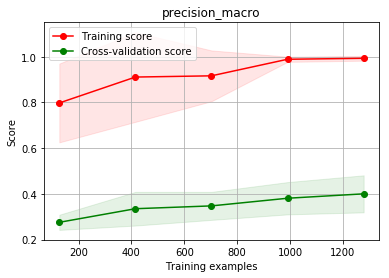

Best parameters set found on development set:
{'C': 100, 'gamma': 0.01}
Grid scores on development set:
0.264 (+/-0.118) for {'C': 1, 'gamma': 1}
0.192 (+/-0.029) for {'C': 1, 'gamma': 0.01}
0.183 (+/-0.028) for {'C': 1, 'gamma': 0.001}
0.071 (+/-0.001) for {'C': 1, 'gamma': 0.0001}
0.226 (+/-0.075) for {'C': 10, 'gamma': 1}
0.281 (+/-0.064) for {'C': 10, 'gamma': 0.01}
0.190 (+/-0.029) for {'C': 10, 'gamma': 0.001}
0.182 (+/-0.029) for {'C': 10, 'gamma': 0.0001}
0.226 (+/-0.075) for {'C': 100, 'gamma': 1}
0.283 (+/-0.114) for {'C': 100, 'gamma': 0.01}
0.220 (+/-0.083) for {'C': 100, 'gamma': 0.001}
0.191 (+/-0.032) for {'C': 100, 'gamma': 0.0001}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          3       0.56      0.50      0.53        10
          4       1.00      0.06      0.11        53
          5       0.71      0.80      0.75     

/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2

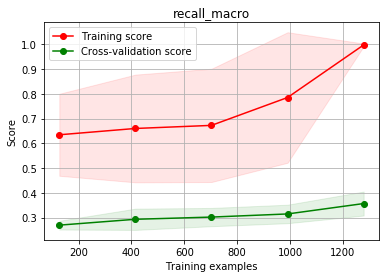

Best parameters set found on development set:
{'C': 100, 'gamma': 0.01}
Grid scores on development set:
0.231 (+/-0.042) for {'C': 1, 'gamma': 1}
0.231 (+/-0.030) for {'C': 1, 'gamma': 0.01}
0.223 (+/-0.030) for {'C': 1, 'gamma': 0.001}
0.167 (+/-0.000) for {'C': 1, 'gamma': 0.0001}
0.225 (+/-0.053) for {'C': 10, 'gamma': 1}
0.255 (+/-0.039) for {'C': 10, 'gamma': 0.01}
0.229 (+/-0.031) for {'C': 10, 'gamma': 0.001}
0.223 (+/-0.030) for {'C': 10, 'gamma': 0.0001}
0.224 (+/-0.052) for {'C': 100, 'gamma': 1}
0.274 (+/-0.110) for {'C': 100, 'gamma': 0.01}
0.231 (+/-0.035) for {'C': 100, 'gamma': 0.001}
0.230 (+/-0.033) for {'C': 100, 'gamma': 0.0001}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          3       0.56      0.50      0.53        10
          4       1.00      0.06      0.11        53
          5       0.71      0.80      0.75     

In [12]:
scores = ['accuracy', 'precision_macro', 'recall_macro']

tuned_parameters = [{'gamma': [1, 1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100]}]

for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(svm.SVC(kernel='rbf'), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, score, X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print


# Linear Kernel Grid Search

# Tuning hyper-parameters for accuracy


/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2

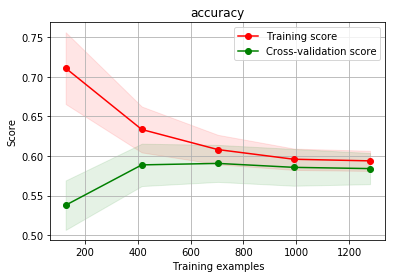

Best parameters set found on development set:
{'C': 100}
Grid scores on development set:
0.557 (+/-0.088) for {'C': 1}
0.558 (+/-0.087) for {'C': 10}
0.559 (+/-0.086) for {'C': 100}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          3       0.00      0.00      0.00        10
          4       0.00      0.00      0.00        53
          5       0.65      0.78      0.71       681
          6       0.52      0.65      0.58       638
          7       0.00      0.00      0.00       199
          8       0.00      0.00      0.00        18

avg / total       0.49      0.59      0.53      1599


# Tuning hyper-parameters for precision_macro


/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anacond

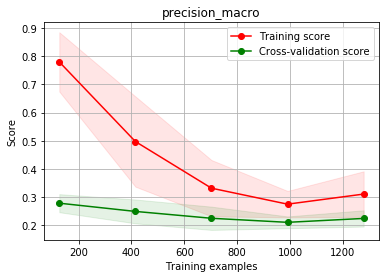

Best parameters set found on development set:
{'C': 100}
Grid scores on development set:
0.196 (+/-0.031) for {'C': 1}
0.197 (+/-0.031) for {'C': 10}
0.197 (+/-0.032) for {'C': 100}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          3       0.00      0.00      0.00        10
          4       0.00      0.00      0.00        53
          5       0.65      0.78      0.71       681
          6       0.52      0.65      0.58       638
          7       0.00      0.00      0.00       199
          8       0.00      0.00      0.00        18

avg / total       0.49      0.59      0.53      1599


# Tuning hyper-parameters for recall_macro


/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2

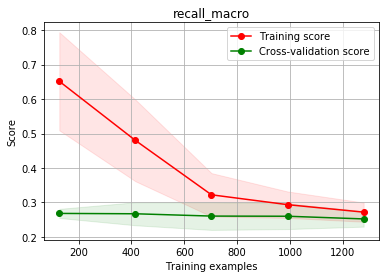

Best parameters set found on development set:
{'C': 100}
Grid scores on development set:
0.227 (+/-0.030) for {'C': 1}
0.228 (+/-0.030) for {'C': 10}
0.228 (+/-0.030) for {'C': 100}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          3       0.00      0.00      0.00        10
          4       0.00      0.00      0.00        53
          5       0.65      0.78      0.71       681
          6       0.52      0.65      0.58       638
          7       0.00      0.00      0.00       199
          8       0.00      0.00      0.00        18

avg / total       0.49      0.59      0.53      1599




In [13]:
tuned_parameters = [{'C': [1, 10, 100]}]

for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(svm.SVC(kernel='linear'), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, score, X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print


# Poly Kernel Grid Search

# Tuning hyper-parameters for accuracy


/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2

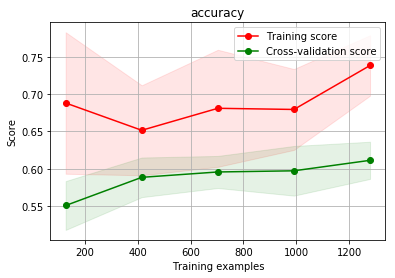

Best parameters set found on development set:
{'C': 1, 'decision_function_shape': 'ovo', 'degree': 1}
Grid scores on development set:
0.567 (+/-0.079) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 1}
0.505 (+/-0.053) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 2}
0.564 (+/-0.068) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 3}
0.505 (+/-0.032) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 4}
0.567 (+/-0.079) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 1}
0.505 (+/-0.053) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 2}
0.564 (+/-0.068) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 3}
0.505 (+/-0.032) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 4}
0.558 (+/-0.086) for {'C': 10, 'decision_function_shape': 'ovo', 'degree': 1}
0.511 (+/-0.055) for {'C': 10, 'decision_function_shape': 'ovo', 'degree': 2}
0.547 (+/-0.068) for {'C': 10, 'decision_function_shape': 'ovo', 'degree': 3}
0.467 (+/-0.046)

/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anacond

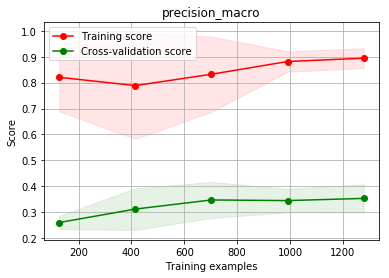

Best parameters set found on development set:
{'C': 100, 'decision_function_shape': 'ovo', 'degree': 3}
Grid scores on development set:
0.189 (+/-0.031) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 1}
0.262 (+/-0.071) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 2}
0.297 (+/-0.133) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 3}
0.271 (+/-0.089) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 4}
0.189 (+/-0.031) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 1}
0.262 (+/-0.071) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 2}
0.297 (+/-0.133) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 3}
0.271 (+/-0.089) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 4}
0.197 (+/-0.031) for {'C': 10, 'decision_function_shape': 'ovo', 'degree': 1}
0.263 (+/-0.057) for {'C': 10, 'decision_function_shape': 'ovo', 'degree': 2}
0.298 (+/-0.063) for {'C': 10, 'decision_function_shape': 'ovo', 'degree': 3}
0.249 (+/-0.06

/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2

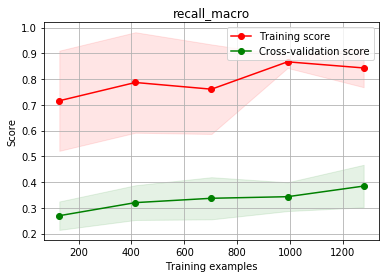

Best parameters set found on development set:
{'C': 100, 'decision_function_shape': 'ovo', 'degree': 3}
Grid scores on development set:
0.228 (+/-0.032) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 1}
0.223 (+/-0.023) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 2}
0.272 (+/-0.097) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 3}
0.239 (+/-0.058) for {'C': 1, 'decision_function_shape': 'ovo', 'degree': 4}
0.228 (+/-0.032) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 1}
0.223 (+/-0.023) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 2}
0.272 (+/-0.097) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 3}
0.239 (+/-0.058) for {'C': 1, 'decision_function_shape': 'ovr', 'degree': 4}
0.227 (+/-0.030) for {'C': 10, 'decision_function_shape': 'ovo', 'degree': 1}
0.243 (+/-0.073) for {'C': 10, 'decision_function_shape': 'ovo', 'degree': 2}
0.285 (+/-0.071) for {'C': 10, 'decision_function_shape': 'ovo', 'degree': 3}
0.242 (+/-0.07

In [14]:
tuned_parameters = [{'C': [1, 10, 100],
                     'degree': [1, 2, 3, 4],
                     'decision_function_shape': ['ovo', 'ovr']}]

for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(svm.SVC(kernel='poly'), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, score, X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print


# Sigmoid Kernel

# Tuning hyper-parameters for accuracy


/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2

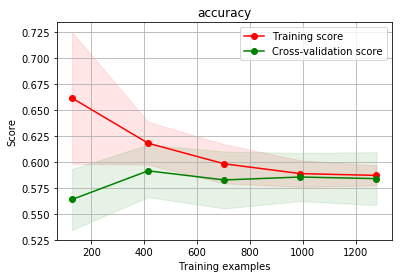

Best parameters set found on development set:
{'C': 100, 'decision_function_shape': 'ovo', 'gamma': 0.001}
Grid scores on development set:
0.429 (+/-0.073) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1}
0.564 (+/-0.085) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01}
0.537 (+/-0.088) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001}
0.426 (+/-0.004) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.0001}
0.429 (+/-0.073) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 1}
0.564 (+/-0.085) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.01}
0.537 (+/-0.088) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.001}
0.426 (+/-0.004) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.0001}
0.432 (+/-0.100) for {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 1}
0.560 (+/-0.100) for {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.01}
0.565 (+/-0.084) for {'C': 10, 'decision_function_shape': 'ovo', 'gamma'

/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rocket/anacond

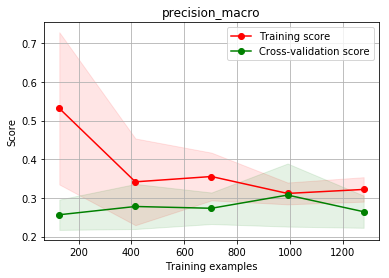

Best parameters set found on development set:
{'C': 100, 'decision_function_shape': 'ovo', 'gamma': 1}
Grid scores on development set:
0.232 (+/-0.077) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1}
0.187 (+/-0.034) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01}
0.175 (+/-0.032) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001}
0.071 (+/-0.001) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.0001}
0.232 (+/-0.077) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 1}
0.187 (+/-0.034) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.01}
0.175 (+/-0.032) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.001}
0.071 (+/-0.001) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.0001}
0.237 (+/-0.082) for {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 1}
0.213 (+/-0.068) for {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.01}
0.188 (+/-0.033) for {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.

/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/home/rocket/anaconda2

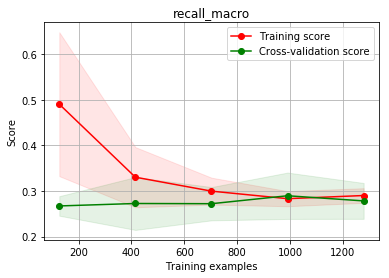

Best parameters set found on development set:
{'C': 100, 'decision_function_shape': 'ovo', 'gamma': 0.01}
Grid scores on development set:
0.212 (+/-0.053) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1}
0.227 (+/-0.035) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01}
0.215 (+/-0.037) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.001}
0.167 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.0001}
0.212 (+/-0.053) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 1}
0.227 (+/-0.035) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.01}
0.215 (+/-0.037) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.001}
0.167 (+/-0.000) for {'C': 1, 'decision_function_shape': 'ovr', 'gamma': 0.0001}
0.213 (+/-0.063) for {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 1}
0.235 (+/-0.051) for {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 0.01}
0.227 (+/-0.035) for {'C': 10, 'decision_function_shape': 'ovo', 'gamma':

In [15]:
tuned_parameters = [{'gamma': [1, 1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100],
                     'decision_function_shape': ['ovo', 'ovr']}]
for score in scores:
    plt.clf()
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(svm.SVC(kernel='sigmoid'), tuned_parameters, cv=5, verbose=0, scoring=score, n_jobs=4)
    clf.fit(X, y)

    plot_learning_curve(clf, score, X, y, ylim=None, cv=cv, n_jobs=4).show()

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print

    print("Detailed classification report:")
    print
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print
    y_true, y_pred = y, clf.predict(X)
    print(classification_report(y_true, y_pred))
    print
